In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5


f(3.0)

20.0

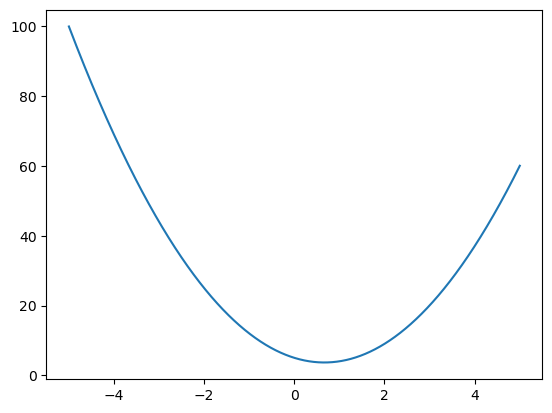

In [3]:
end = 5
step = 0.0025
xs = np.arange(-end, end+step, step)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [4]:
h = 0.0001
x = 2/3
tangent1 = (f(x + h) - f(x))/h
tangent1

0.0002999999981767587

In [5]:
h = 0.0001
x = -2/3
tangent2 = (f(x + h) - f(x))/h
tangent2

-7.99969999999206

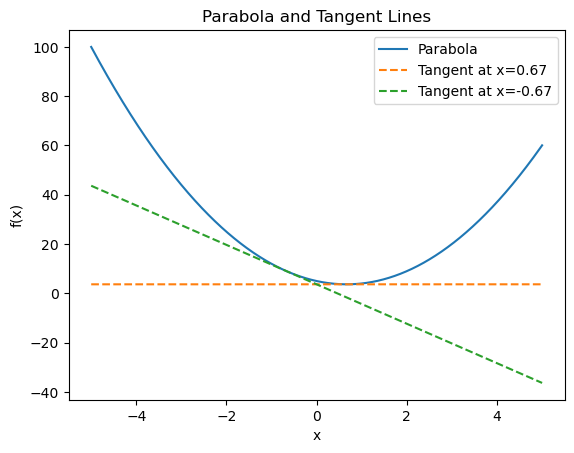

In [6]:
points = [2/3, -2/3]
slopes = [tangent1, tangent2]


def plot_tangent(x0, slope, label):
    y0 = f(x0)
    tangent_line = slope * (xs - x0) + y0
    plt.plot(xs, tangent_line, '--', label=label)


plt.plot(xs, ys, label='Parabola')

for i, point in enumerate(points):
    plot_tangent(point, slopes[i], f'Tangent at x={point:.2f}')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Parabola and Tangent Lines')
plt.legend()
plt.show()

In [7]:
# let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [10]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={
                  'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (
            n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [11]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other_instance):
        other_instance = other_instance if isinstance(
            other_instance, Value) else Value(other_instance)
        out = Value(self.data + other_instance.data,
                    (self, other_instance), '+')

        def _backward():
            self.grad += out.grad * 1.0
            other_instance.grad += out.grad * 1.0
        out._backward = _backward
        return out

    def __mul__(self, other_instance):
        other_instance = other_instance if isinstance(
            other_instance, Value) else Value(other_instance)
        out = Value(self.data * other_instance.data,
                    (self, other_instance), '*')

        def _backward():
            self.grad += out.grad * other_instance.data
            other_instance.grad += out.grad * self.data
        out._backward = _backward
        return out

    def __pow__(self, exponent):
        assert isinstance(exponent, (int, float)
                          ), "Only supporting int/float powers for now."
        out = Value(self.data ** exponent, (self, ), f'**{exponent}')

        def _backward():
            self.grad += out.grad * (exponent * self.data ** (exponent - 1))
        out._backward = _backward
        return out

    def __radd__(self, other_instance):
        return self + other_instance

    def __rmul__(self, other_instance):
        return self * other_instance

    def __truediv__(self, other_instance):
        return self * other_instance**-1

    def __neg__(self):
        return self * (-1)

    def __sub__(self, other_instance):
        return self + (-other_instance)

    def tanh(self):
        value = self.data
        tanh = (math.exp(2 * value) - 1) / (math.exp(2 * value) + 1)
        out = Value(tanh, (self, ), 'tanh')

        def _backward():
            self.grad += out.grad * (1 - tanh**2)
        out._backward = _backward
        return out

    def exp(self):
        value = self.data
        out = Value(math.exp(value), (self, ), 'exp')

        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

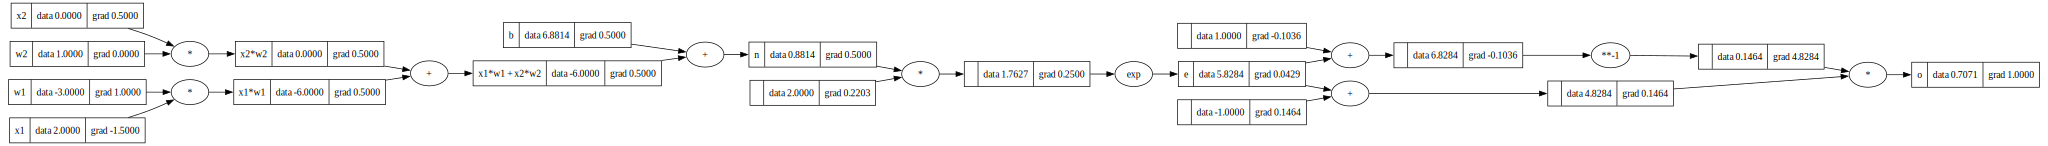

In [12]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

e = (n * 2).exp()
e.label = 'e'

o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()
draw_dot(o)

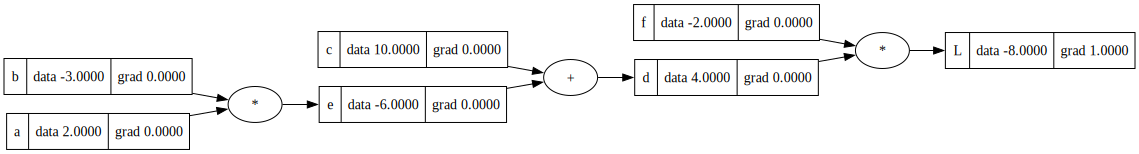

In [13]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c
d.label = 'd'
f = Value(-2.0, label='f')
L = d * f
L.label = 'L'
L.grad = 1.0
draw_dot(L)

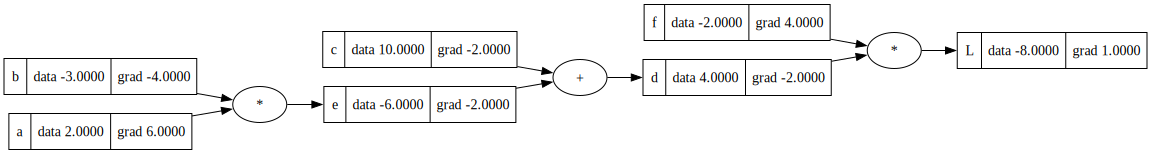

In [14]:
d.grad = -2.0
f.grad = 4.0
# dL/de = dL/dd * dd/de = -2.0 * 1.0 = -2.0
e.grad = -2.0
c.grad = -2.0
# dL/da = dL/de * de/da = -2.0 * -3.0 = 6.0
a.grad = 6.0
b.grad = -4.0
draw_dot(L)

In [15]:
delta = 0.01
a.data += delta * a.grad
b.data += delta * b.grad
c.data += delta * c.grad
f.data += delta * f.grad
e = a * b
d = e + c
L = d * f
print(L.data)

-7.286496


In [16]:
def lol():

    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    a.data += h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)

lol()

6.000000000021544


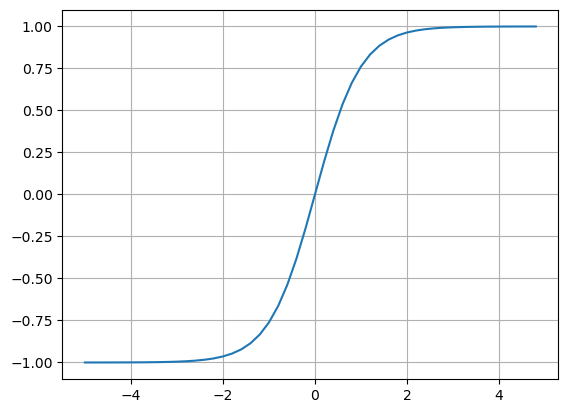

In [17]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()
plt.show()

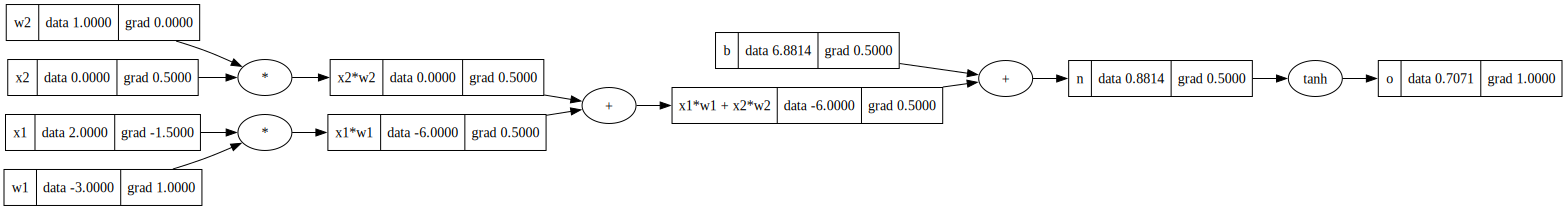

In [18]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

o.backward()
draw_dot(o)

In [19]:
topo = []
visited = set()


def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)


build_topo(o)
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

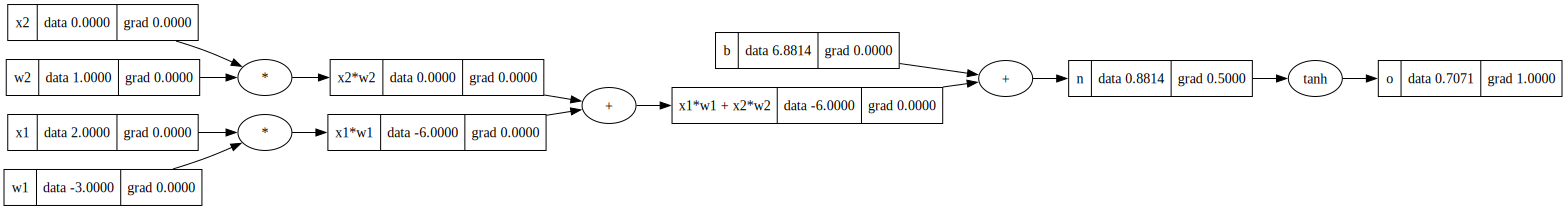

In [20]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1
x1w1.label = 'x1*w1'
x2w2 = x2 * w2
x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'
o.grad = 1

o._backward()
draw_dot(o)

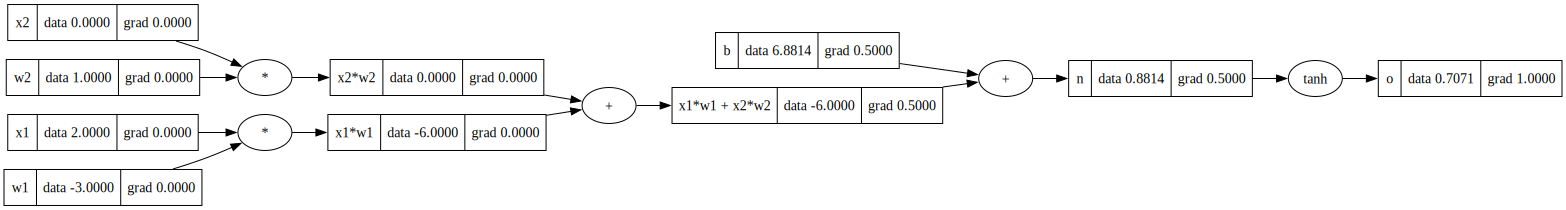

In [21]:
n._backward()
draw_dot(o)

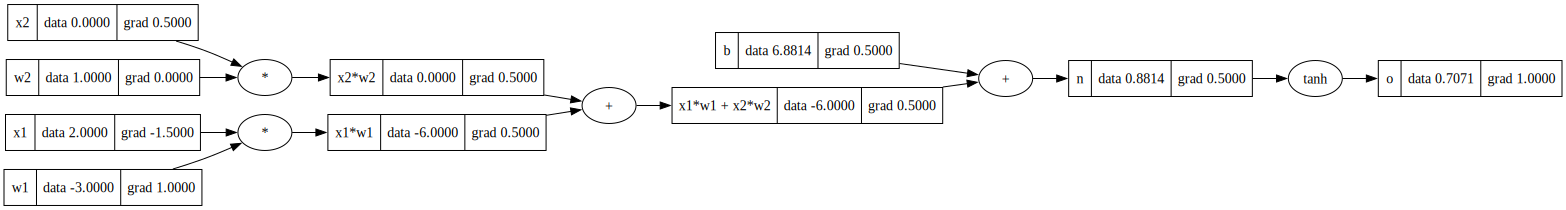

In [22]:
n.grad = 0.5
x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

w1.grad = 1.0
x1.grad = -1.5
w2.grad = 0.0
x2.grad = 0.5

draw_dot(o)

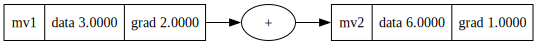

In [23]:
mulv1 = Value(3.0, label='mv1')
mulv2 = mulv1 + mulv1
mulv2.label = 'mv2'
mulv2.backward()
draw_dot(mulv2)

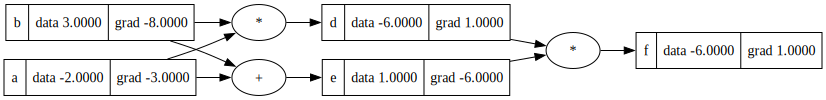

In [24]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b
d.label = 'd'
e = a + b
e.label = 'e'
f = d * e
f.label = 'f'

f.backward()
draw_dot(f)
# df/de = -6.0
# df/dd = 1.0
# df/da = df/de * de/da + df/dd * dd/da = -6.0 * 1.0 + 1.0 * 3.0 = -3.0
# df/db = df/de * de/db + df/dd * dd/db = -6.0 * 1.0 + 1.0 * -2.0 = -8.0